In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = 'Project_Dataset.xlsx'
excel_data = pd.ExcelFile(file_path)

# Display sheet names to understand the structure of the file
excel_data.sheet_names

['Customer Transaction Data',
 'Website Analytics',
 'Market Research Reports',
 'Customer Demographics',
 'Cluster Analysis',
 'Technology Usage Data',
 'Product Recommendation Data']

In [4]:
##Cleaning the data

# Load the data from the 'Customer Demographics' sheet
df = pd.read_excel(file_path, sheet_name='Customer Demographics')

# Skip initial rows and identify the correct headers and data
df_cleaned = pd.read_excel(file_path, sheet_name='Customer Demographics', skiprows=5)

# Rename columns appropriately
columns = [
    'Category', 'Total', 'Total (%)', 'Female', 'Female (%)', 'Male', 'Male (%)',
    'Age 18-29', 'Age 18-29 (%)', 'Age 30-49', 'Age 30-49 (%)', 'Age 50+', 'Age 50+ (%)',
    'Income <= 22,800', 'Income <= 22,800 (%)', 'Income 22,800-43,200', 'Income 22,800-43,200 (%)',
    'Income 43,200-98,400', 'Income 43,200-98,400 (%)', 'Income > 98,400', 'Income > 98,400 (%)',
    'Income Prefer not to say', 'Income Prefer not to say (%)'
]
df_cleaned.columns = columns

# Drop rows with non-numeric data in the 'Total' column
df_cleaned = df_cleaned[pd.to_numeric(df_cleaned['Total'], errors='coerce').notnull()]

# Convert numeric columns to appropriate data types
numeric_columns = columns[1::2]
df_cleaned[numeric_columns] = df_cleaned[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Identify and clean specific problematic values
unique_values = pd.unique(df_cleaned.values.ravel('K'))
unique_values_with_superscript = [val for val in unique_values if isinstance(val, str) and '¹' in val]
replacements = {val: val.replace('¹', '') for val in unique_values_with_superscript}
df_cleaned.replace(replacements, inplace=True)

# Convert numeric columns to appropriate data types again
df_cleaned[numeric_columns] = df_cleaned[numeric_columns].apply(pd.to_numeric)


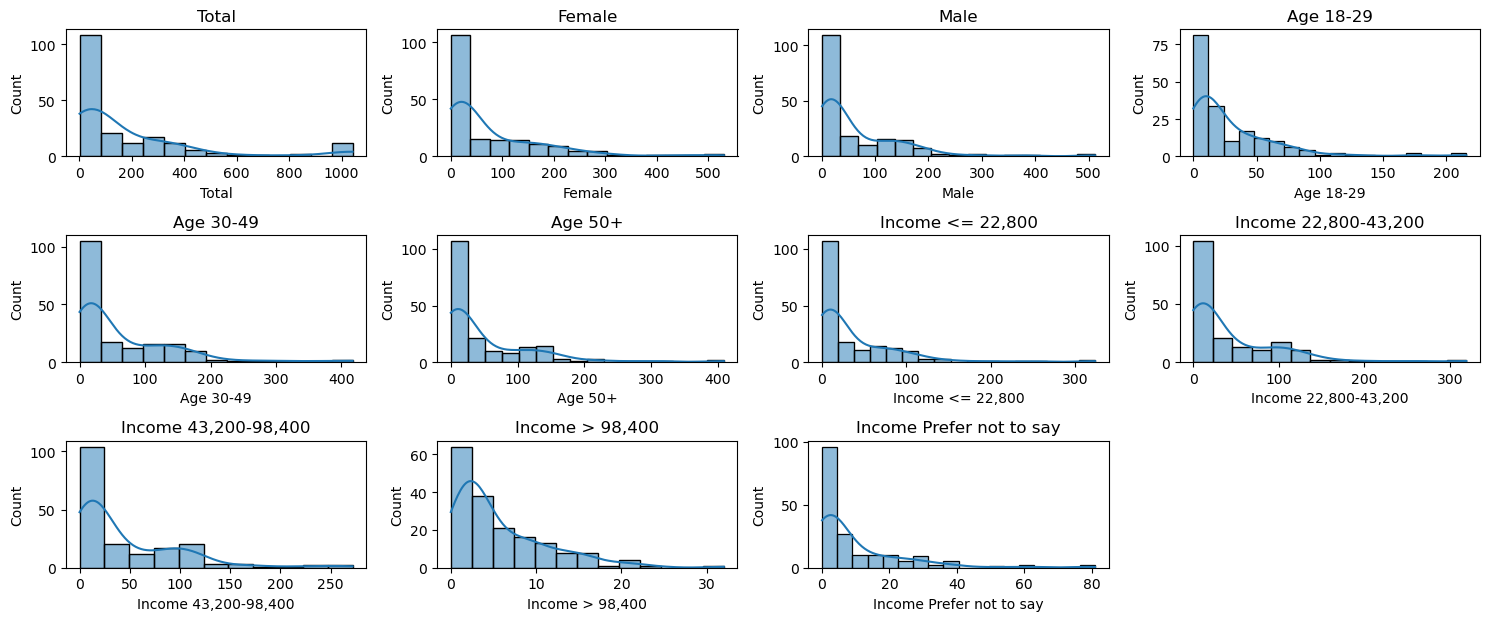

In [5]:
# Plot distributions for each numeric column
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(df_cleaned[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

# Selecting relevant columns for clustering (dropping '%' columns)
clustering_columns = [col for col in numeric_columns if ' (%)' not in col]
data_for_clustering = df_cleaned[clustering_columns]

# Standardizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

data_scaled_df = pd.DataFrame(data_scaled, columns=clustering_columns)

In [6]:
# Fill missing values with the mean of their respective columns
data_scaled_df.fillna(data_scaled_df.mean(), inplace=True)

# Verify if there are no more missing values
data_scaled_df.isnull().sum()


Total                       0
Female                      0
Male                        0
Age 18-29                   0
Age 30-49                   0
Age 50+                     0
Income <= 22,800            0
Income 22,800-43,200        0
Income 43,200-98,400        0
Income > 98,400             0
Income Prefer not to say    0
dtype: int64

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using the Elbow method
inertia = []
silhouette_scores = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled_df)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(data_scaled_df, kmeans.labels_))


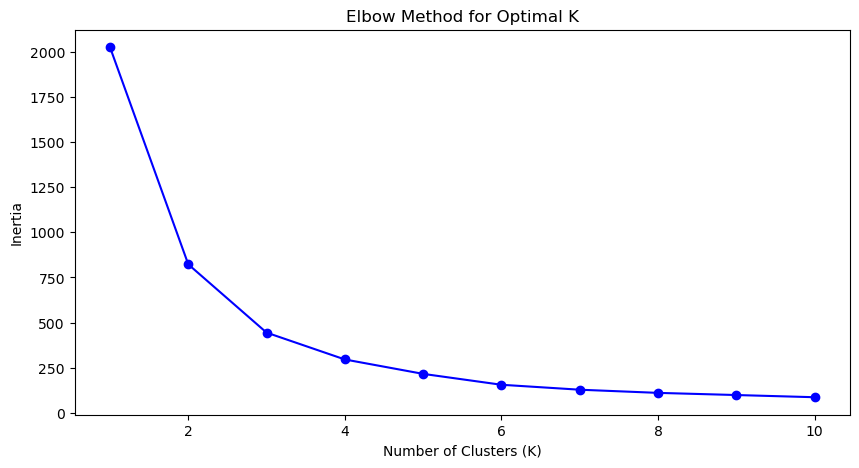

In [8]:
# Plot the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

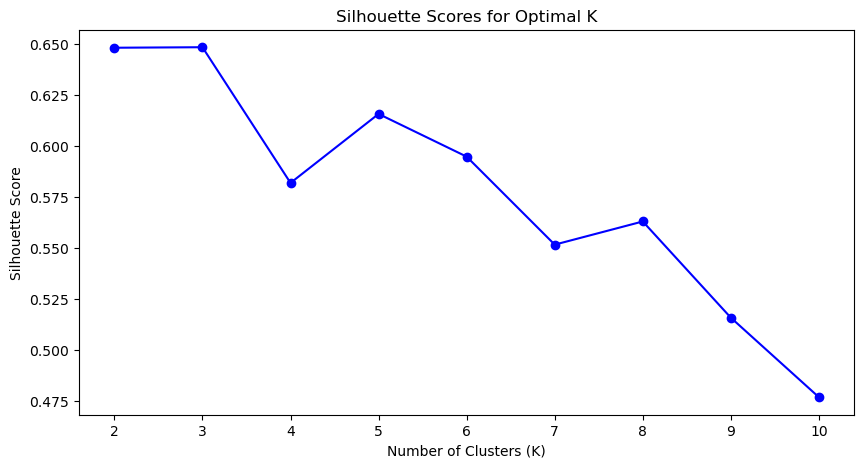

In [9]:
# Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K[1:], silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal K')
plt.show()

In [10]:
# Apply K-means clustering for K=3 and K=4
kmeans_3 = KMeans(n_clusters=3, random_state=42)

clusters_3 = kmeans_3.fit_predict(data_scaled_df)


In [11]:
# Add cluster labels to the original dataframe
df_cleaned['Cluster_3'] = clusters_3


In [12]:
# Analyze the clusters
cluster_analysis_3 = df_cleaned.groupby('Cluster_3').mean()

In [13]:
# Analyze the clusters
cluster_analysis_3 = df_cleaned.groupby('Cluster_3').mean()

cluster_analysis_3.to_csv('Cluster_Analysis_K3.csv')

cluster_analysis_3

,Total,Female,Male,Age 18-29,Age 30-49,Age 50+,"Income <= 22,800","Income 22,800-43,200","Income 43,200-98,400","Income > 98,400",Income Prefer not to say
Cluster_3,,,,,,,,,,,
0,47.641221,25.778626,21.862595,12.488550,22.290076,12.862595,11.557252,13.763359,16.244275,3.061069,3.015267
1,449.576271,180.040816,148.632653,62.382979,144.877551,122.387755,87.645833,102.714286,102.020408,13.348837,23.162791
2,890.200000,474.200000,416.000000,183.600000,367.600000,339.000000,267.000000,272.800000,244.800000,32.000000,65.800000


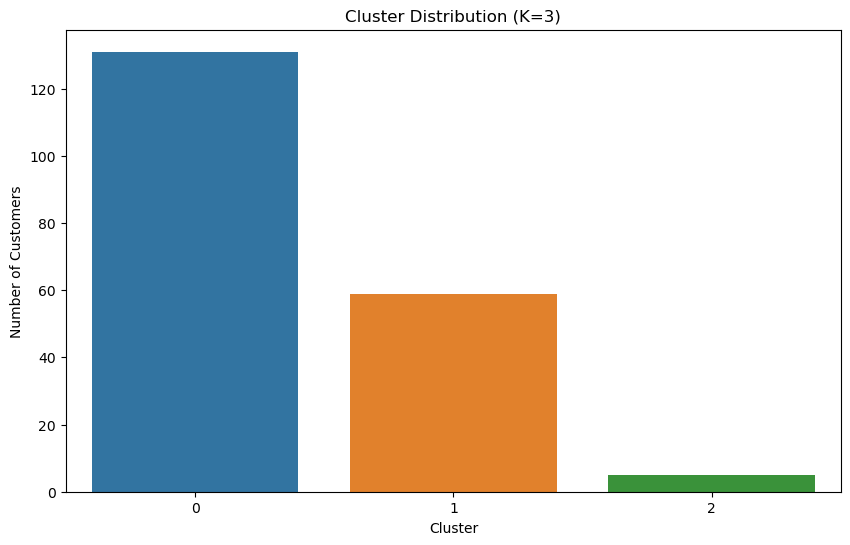

In [14]:
#For K=3
# Cluster Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster_3', data=df_cleaned)
plt.title('Cluster Distribution (K=3)')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


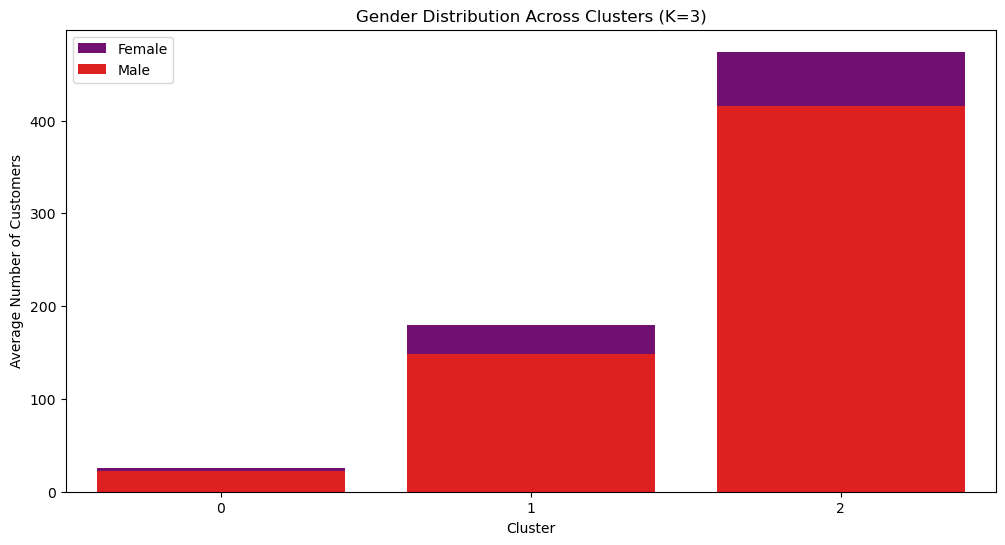

In [15]:
# Gender Distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster_3', y='Female', data=df_cleaned, ci=None, label='Female', color = 'purple')
sns.barplot(x='Cluster_3', y='Male', data=df_cleaned, ci=None, label='Male', color='red')
plt.title('Gender Distribution Across Clusters (K=3)')
plt.xlabel('Cluster')
plt.ylabel('Average Number of Customers')
plt.legend()
plt.show()

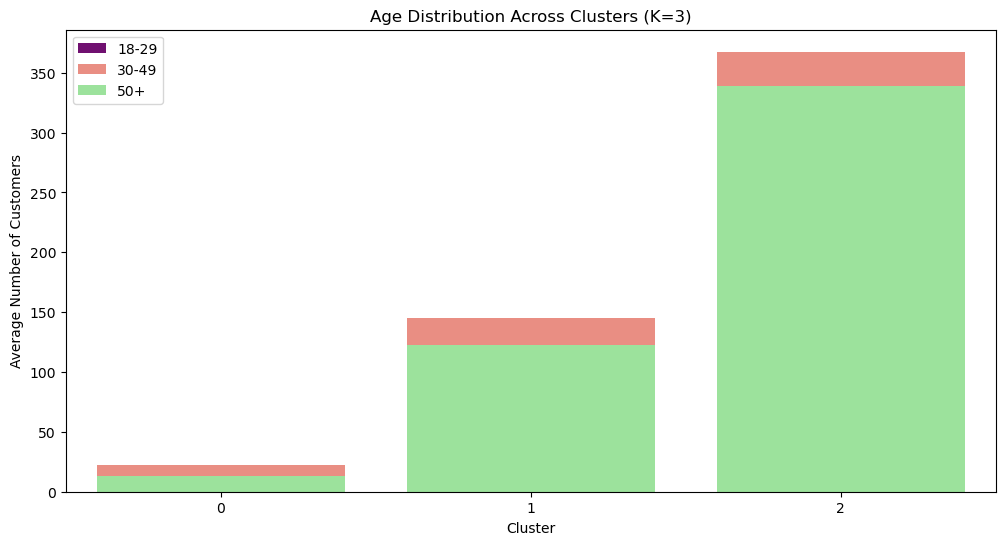

In [16]:
# Age Distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster_3', y='Age 18-29', data=df_cleaned, ci=None, label='18-29', color = 'purple')
sns.barplot(x='Cluster_3', y='Age 30-49', data=df_cleaned, ci=None, label='30-49', color='salmon')
sns.barplot(x='Cluster_3', y='Age 50+', data=df_cleaned, ci=None, label='50+', color='lightgreen')
plt.title('Age Distribution Across Clusters (K=3)')
plt.xlabel('Cluster')
plt.ylabel('Average Number of Customers')
plt.legend()
plt.show()


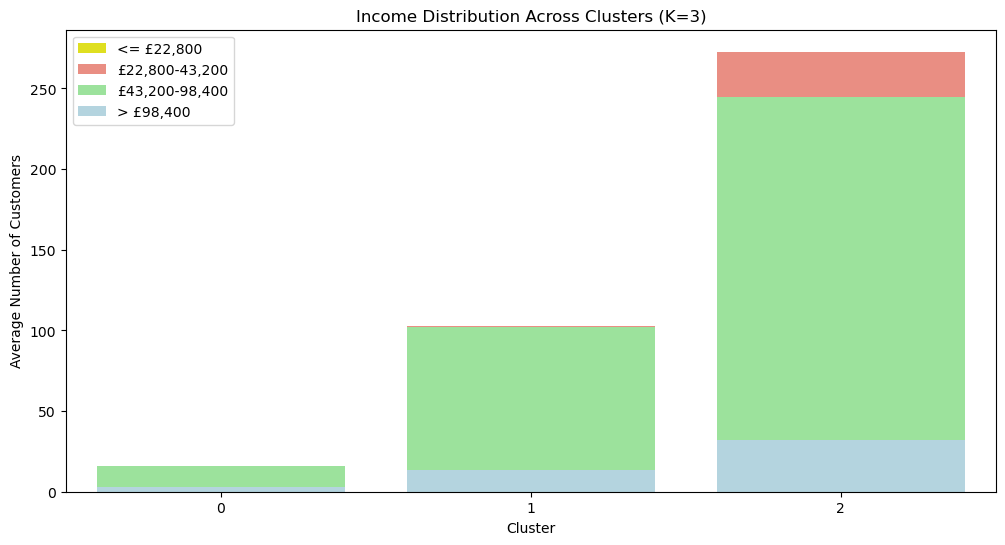

In [17]:
# Income Distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster_3', y='Income <= 22,800', data=df_cleaned, ci=None, label='<= £22,800', color = 'yellow')
sns.barplot(x='Cluster_3', y='Income 22,800-43,200', data=df_cleaned, ci=None, label='£22,800-43,200', color='salmon')
sns.barplot(x='Cluster_3', y='Income 43,200-98,400', data=df_cleaned, ci=None, label='£43,200-98,400', color='lightgreen')
sns.barplot(x='Cluster_3', y='Income > 98,400', data=df_cleaned, ci=None, label='> £98,400', color='lightblue')
plt.title('Income Distribution Across Clusters (K=3)')
plt.xlabel('Cluster')
plt.ylabel('Average Number of Customers')
plt.legend()
plt.show()


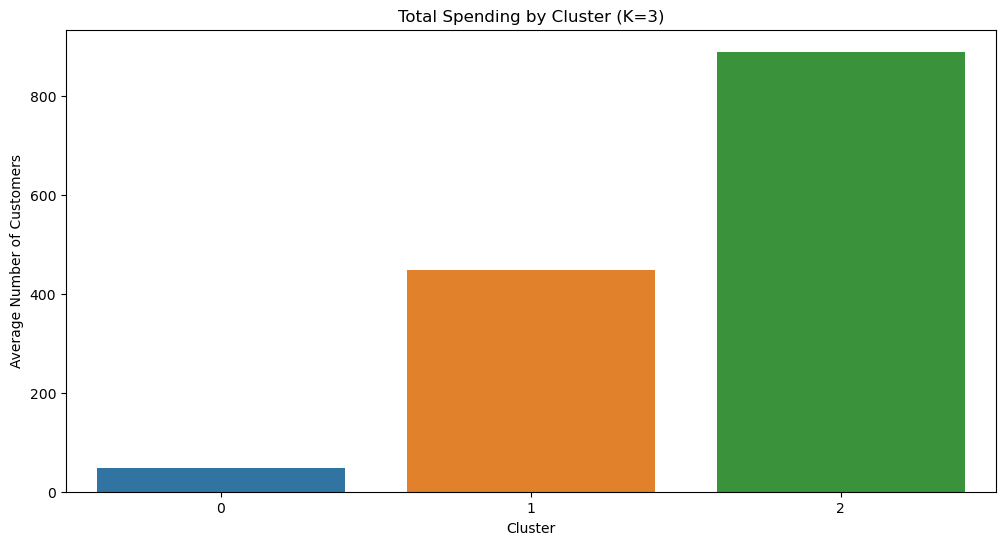

In [18]:
# Total Spending by Cluster
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster_3', y='Total', data=df_cleaned, ci=None)
plt.title('Total Spending by Cluster (K=3)')
plt.xlabel('Cluster')
plt.ylabel('Average Number of Customers')
plt.show()